# Imports and spark config

In [1]:
import os

# Set SPARK_HOME
os.environ["SPARK_HOME"] = r"C:/Spark/spark-3.5.0-bin-hadoop3"

# Set PYTHONPATH
spark_home = os.environ.get("SPARK_HOME", "")
if spark_home:
    python_path = os.path.join(spark_home, "python")
    py4j_zip = os.path.join(spark_home, "python", "lib", "py4j-0.10.9.7-src.zip")
    os.environ["PYTHONPATH"] = f"{python_path};{py4j_zip};{os.environ.get('PYTHONPATH', '')}"

# Set PYSPARK_PYTHON
os.environ["PYSPARK_PYTHON"] = r"C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe"
print(os.environ.get('PYSPARK_PYTHON'))

# Set PATH
if spark_home:
    os.environ["PATH"] = f"{python_path};{os.path.join(spark_home, 'bin')};{os.environ.get('PATH', '')}"

C:\Users\Vincenzo\AppData\Local\Programs\Python\Python38\python.exe


In [2]:
import findspark
findspark.init()

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [3]:
spark = SparkSession.builder.appName("spark").config("spark.driver.memory", "24g").getOrCreate()
spark

In [4]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [5]:
df = spark.read.parquet(r"c:\Users\Vincenzo\PROJECTS\DDAM_data\brewery\brewery_data_complete_extended.parquet")
type(df)

pyspark.sql.dataframe.DataFrame

In [6]:
from pyspark.sql.functions import split, col

# Split the ratio_column into three parts based on the colon delimiter
split_col = split(col("Ingredient_Ratio"), ":")

# Create three separate columns for water, grains, and hops
df = df.withColumn("water", split_col.getItem(0).cast("double"))
df = df.withColumn("grains", split_col.getItem(1).cast("double"))
df = df.withColumn("hops", split_col.getItem(2).cast("double"))
df = df.drop("Ingredient_Ratio")

In [7]:
# Define a new column with the USD per liter ratio and brewing efficiency
df = df.withColumn("USD_per_Liter", F.col("Total_Sales") / F.col("Volume_Produced").cast("double"))
df = df.withColumn("Brewing_efficency", F.col("Brewhouse_Efficiency") / F.col("Volume_Produced").cast("double"))

In [8]:
from pyspark.sql.types import StringType

# Identify numerical and non-numerical columns
numerical_cols = [col_name for col_name, data_type in df.dtypes if data_type != 'string']
categorical_cols = [col_name for col_name, data_type in df.dtypes if data_type == 'string']

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['Batch_ID', 'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'water', 'grains', 'hops', 'USD_per_Liter', 'Brewing_efficency']
Categorical columns: ['Brew_Date', 'Beer_Style', 'SKU', 'Location']


In [9]:
# functions

from pyspark.sql.functions import when, col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, dense_rank, when
from pyspark.sql.window import Window

def ordinal_encode_pyspark(df, input_col, output_col):
    """ Ordinal encodes a column within a PySpark DataFrame

    Args:
        df (pyspark.sql.DataFrame): The input Spark DataFrame.
        input_col (str): Name of the column to be encoded. Defaults to "Bitterness".
        output_col (str): Name for the new ordinal encoded column. Defaults to "Bitterness_ordinal".
    
    Returns:
        pyspark.sql.DataFrame: The Spark DataFrame with the ordinal encoded column.
    """

    window = Window.orderBy(input_col) 
    return df.withColumn(output_col, dense_rank().over(window)) \
             .withColumn(output_col, when(col(input_col).isNull(), 0).otherwise(col(output_col))) \
             #.drop(input_col)
             
def check_distinct_values(df, feature_col):
    """  
    Prints the distinct values of a feature in a PySpark DataFrame.

    Args:
        df (pyspark.sql.DataFrame): The PySpark DataFrame.
        feature_col (str): The name of the feature column.
    """

    distinct_values = df.select(feature_col).distinct().collect()

    print(f"Distinct values in '{feature_col}':")
    for row in distinct_values:
        print(row[feature_col]) 

    # functions

def one_hot_encode_column(df, input_col, output_col_prefix="encoded"):
    """ One-hot encodes a specified categorical column, drops intermediary columns,
        and allows for specifying the prefix of the output columns.

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame.
        input_col (str): The name of the column containing categorical data.
        output_col_prefix (str): Prefix for the generated one-hot encoded column names.

    Returns:
        pyspark.sql.DataFrame: DataFrame with the one-hot encoded column(s) and 
                               intermediary columns removed.
    """

    indexer = StringIndexer(inputCol=input_col, outputCol=input_col + "_index")
    encoder = OneHotEncoder(inputCol=input_col + "_index", outputCol=output_col_prefix + input_col + "features")
    assembler = VectorAssembler(inputCols=[input_col + "_index"], outputCol="features") 

    pipeline = Pipeline(stages=[indexer, assembler, encoder])
    transformed_df = pipeline.fit(df).transform(df)

    # Drop unnecessary columns
    drop_cols = [input_col + "_index", "features"]
    return transformed_df.drop(*drop_cols)  # Dynamic column dropping

def discretize_and_encode(df, input_col="fermentation_time"):
    """ Discretizes a feature into bins, one-hot encodes the bins, and preserves the original column

    Args:
        df (pyspark.sql.DataFrame): Input DataFrame
        input_col (str): Name of the column to be discretized and encoded

    Returns:
        pyspark.sql.DataFrame:  DataFrame with new discretization and encoded columns
    """

    df = df.withColumn(input_col + "_bin", 
                       when((col(input_col) >= 10) & (col(input_col) <= 13), "Short")
                       .when((col(input_col) >= 14) & (col(input_col) <= 16), "Medium")
                       .otherwise("Long"))
    
    return one_hot_encode_column(df, input_col=input_col + "_bin") 

In [10]:
#discretize and encode is hardcoded for fermentation time (!!)

df = discretize_and_encode(df)
df.select("encodedfermentation_time_binfeatures").show(5)

+------------------------------------+
|encodedfermentation_time_binfeatures|
+------------------------------------+
|                           (2,[],[])|
|                       (2,[0],[1.0])|
|                       (2,[0],[1.0])|
|                       (2,[1],[1.0])|
|                       (2,[1],[1.0])|
+------------------------------------+
only showing top 5 rows



In [11]:
df = one_hot_encode_column(df, "Beer_Style")
df.select("encodedBeer_Stylefeatures").show(5)

+-------------------------+
|encodedBeer_Stylefeatures|
+-------------------------+
|                (7,[],[])|
|            (7,[2],[1.0])|
|                (7,[],[])|
|            (7,[0],[1.0])|
|            (7,[3],[1.0])|
+-------------------------+
only showing top 5 rows



In [12]:
df = one_hot_encode_column(df, "SKU")
df.select("encodedSKUfeatures").show(5)

+------------------+
|encodedSKUfeatures|
+------------------+
|         (3,[],[])|
|         (3,[],[])|
|         (3,[],[])|
|         (3,[],[])|
|     (3,[2],[1.0])|
+------------------+
only showing top 5 rows



In [13]:
df = one_hot_encode_column(df, "Location")
df.select("encodedLocationfeatures").show(5)

+-----------------------+
|encodedLocationfeatures|
+-----------------------+
|              (9,[],[])|
|              (9,[],[])|
|          (9,[7],[1.0])|
|          (9,[4],[1.0])|
|          (9,[3],[1.0])|
+-----------------------+
only showing top 5 rows



In [14]:
df = df.drop("Location", "SKU", "Beer_Style", "fermentation_time_bin")
df.printSchema()

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)
 |-- water: double (nullable = true)
 |-- grains: double (nullable = true)
 |-- hops: double (nullable = true)
 |-- USD_per_Liter: double (nullable = true)
 |-- Brewing_efficency: double (nullable = true)
 |-- encodedfermentation_time_binfeatures: vector (nullable = true)


In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler

production_features = ["Fermentation_Time", "Temperature", "pH_Level", "Gravity",  "water", "grains", "hops"] 
assembler_production = VectorAssembler(inputCols=production_features, outputCol="features_production")
scaler_production = StandardScaler(inputCol="features_production", outputCol="features")

pipeline = Pipeline(stages=[assembler_production, scaler_production])
df = pipeline.fit(df).transform(df)

In [16]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType, ArrayType
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors, DenseVector

def calculate_WSSSE(df, prediction_col="prediction", features_col="features"):
    def squared_distance(feature_vec, mean_vec):
        if isinstance(feature_vec, DenseVector) and isinstance(mean_vec, DenseVector):
            return Vectors.squared_distance(feature_vec, mean_vec)
        else:
            return 0.0  # Return 0 if not valid vectors 

    squared_distance_udf = F.udf(squared_distance, DoubleType())

    def extract_values(feature_vec):
        if isinstance(feature_vec, DenseVector): 
            return feature_vec.toArray().tolist() # Extract values directly
        else:
            return Vectors.dense(feature_vec.toArray().tolist())  

    extract_values_udf = F.udf(extract_values, ArrayType(DoubleType())) 

    subquery = df.select(prediction_col, F.explode(extract_values_udf(F.col(features_col))).alias('feature_value')) \
                 .groupBy(prediction_col, 'feature_value') \
                 .agg(F.mean('feature_value').alias('mean_features'))

    wssse = subquery.groupBy(prediction_col) \
                    .agg(F.sum(squared_distance_udf(F.col('feature_value'), F.col('mean_features'))).alias('wssse')) \
                    .select(F.sum('wssse')).collect()[0][0]

    return wssse

wssse = []

for k in [10,20,50]: 
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features").setPredictionCol("prediction")
    predictions = kmeans.fit(df).transform(df)
    print(k)

    wssse.append(calculate_WSSSE(predictions))  # Use our WSSSE calculation

10
20
50


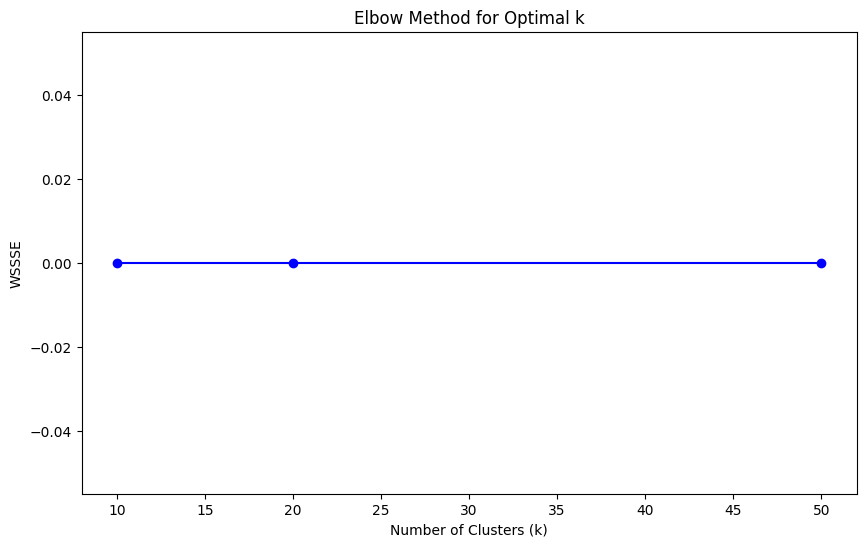

In [18]:
plt.figure(figsize=(10, 6))
plt.plot([10,20,50], wssse, 'bo-')  # Adjust 'k' values here too
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE')
plt.title('Elbow Method for Optimal k')
plt.show()

#### range

In [23]:
# Calculate cost and plot
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features').setPredictionCol('prediction')
    model = kmeans.fit(df)
    cost[k] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

IndexError: index 100 is out of bounds for axis 0 with size 100

#### single values

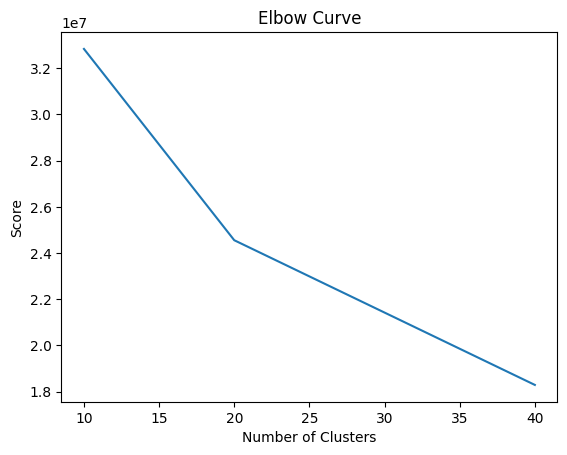

In [22]:
# Calculate cost (specify only the desired values of k)
cost = np.zeros(3)  # Array to store costs for 3 values of k
k_values = [10, 20, 40]

for i, k in enumerate(k_values):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features').setPredictionCol('prediction')
    model = kmeans.fit(df)
    cost[i] = model.summary.trainingCost

# Plot the cost
df_cost = pd.DataFrame(cost)
df_cost.columns = ["cost"]
df_cost.insert(0, 'cluster', k_values)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()
